# Project capstone Literify
Membuat model untuk mengklasifikasikan genre buku berdasarkan cover buku. Dataset yang akan dipakai adalah sebagai berikut :

## Import library yang akan digunakan

In [2]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import re
import os
import string
from ast import literal_eval
import random
%matplotlib inline
import matplotlib.style as style
from urllib.request import urlopen
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [3]:
os.environ['TF_USE_LEGACY_KERAS'] = '1'

## Mengumpulkan data yang akan digunakan

In [4]:
data_df = pd.read_csv('/content/books_data.csv')

## Menilai data yang sudah terkumpulkan

In [5]:
data_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [6]:
data_df.isna().sum()

,0
Title,1
description,68442
authors,31413
image,52075
previewLink,23836
publisher,75886
publishedDate,25305
infoLink,23836
categories,41199
ratingsCount,162652


In [7]:
data_df.describe(include='all')

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
count,212403,143962,180991,160329,188568,136518,187099,188568,171205,49752.000000
unique,212403,133226,127278,149387,188099,16016,11582,184506,10883,NaN
top,Student's Solutions Manual for Johnson/Mowry's...,Unlike some other reproductions of classic tex...,['Rose Arny'],http://books.google.com/books/content?id=7dMSA...,http://books.google.com/books?id=acwPAgAAQBAJ&...,Simon and Schuster,2000,https://play.google.com/store/books/details?id...,['Fiction'],NaN
freq,1,92,236,79,17,3454,4286,18,23419,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.252975
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201.340431
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 non-null  object 
 9   ratingsCount   49752 non-null   float64
dtypes: float64(1), object(9)
memory usage: 16.2+ MB


In [9]:
print(f"duplicate values:{data_df.duplicated().sum()}")

duplicate values:0


In [10]:
data_df.dropna(inplace=True)
data_df.sample(20)

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
38402,Blood and Money,New York Times Bestseller: The “gripping” true...,['Thomas Thompson'],http://books.google.com/books/content?id=U7CzD...,http://books.google.com/books?id=U7CzDQAAQBAJ&...,Open Road Media,2016-12-13,https://play.google.com/store/books/details?id...,['True Crime'],4.0
51736,"Mandie and the Foreign Spies (Mandie, Book 15)","When Mandie and her friends get to Europe, the...",['Lois Gladys Leppard'],http://books.google.com/books/content?id=veKuA...,http://books.google.com/books?id=veKuAAAACAAJ&...,Turtleback,1990-01-01,http://books.google.com/books?id=veKuAAAACAAJ&...,['Juvenile Fiction'],4.0
15416,The confession of Brother Haluin,"In the winter of 1142, snow blankets the Bendi...",['Ellis Peters'],http://books.google.com/books/content?id=iETxP...,http://books.google.nl/books?id=iETxPgAACAAJ&d...,Sphere,1994,http://books.google.nl/books?id=iETxPgAACAAJ&d...,"['Cadfael, Brother (Fictitious character)']",1.0
176736,Robots,"An accessible and engaging account of robots, ...",['John M. Jordan'],http://books.google.com/books/content?id=22M4D...,http://books.google.com/books?id=22M4DQAAQBAJ&...,MIT Press,2016-10-14,http://books.google.com/books?id=22M4DQAAQBAJ&...,['Technology & Engineering'],1.0
55309,A Second Chicken Soup for the Woman's Soul: 10...,This shining collection brings you inspiration...,"['Jack Canfield', 'Mark Victor Hansen']",http://books.google.com/books/content?id=UWsEg...,http://books.google.com/books?id=UWsEgG-xIcwC&...,Simon and Schuster,2012-08-07,https://play.google.com/store/books/details?id...,['Self-Help'],6.0
151642,The Stud,Four Portland friends navigate the complexitie...,['Monica Drake'],http://books.google.com/books/content?id=NgWVb...,http://books.google.com/books?id=NgWVbUqxrJgC&...,Hogarth Press,2013,http://books.google.com/books?id=NgWVbUqxrJgC&...,['Fiction'],6.0
58823,The Castle of Llyr,Master Dallben has decided it is time for Eilo...,['Lloyd Alexander'],http://books.google.com/books/content?id=AHmWB...,http://books.google.com/books?id=AHmWBQAAQBAJ&...,Usborne Publishing Ltd,2014-12-01,http://books.google.com/books?id=AHmWBQAAQBAJ&...,['Juvenile Fiction'],32.0
165642,The Marvellous Land of Snergs,"Located somewhere in ""a world apart,"" just bey...",['E. A. Wyke-Smith'],http://books.google.com/books/content?id=Bq7DA...,http://books.google.com/books?id=Bq7DAgAAQBAJ&...,Courier Corporation,2012-07-12,https://play.google.com/store/books/details?id...,['Juvenile Fiction'],2.0
208389,Edgar Cayce Collection: 4 Volumes in 1,The mystic philosophies of a most intriguing a...,"['Edgar Cayce', 'Hugh Lynn Cayce']",http://books.google.com/books/content?id=z4UYA...,http://books.google.com/books?id=z4UYAQAAMAAJ&...,Random House Value Publishing,1986,http://books.google.com/books?id=z4UYAQAAMAAJ&...,['Cooking'],1.0
162628,Casting a Spell: The Bamboo Fly Rod and the Am...,An avid fisherman offers a personal and cultur...,['George Black'],http://books.google.com/books/content?id=m8nNw...,http://books.google.com/books?id=m8nNwAEACAAJ&...,Random House Incorporated,2006,http://books.google.com/books?id=m8nNwAEACAAJ&...,['Sports & Recreation'],2.0


In [11]:
data_df.shape

(40635, 10)

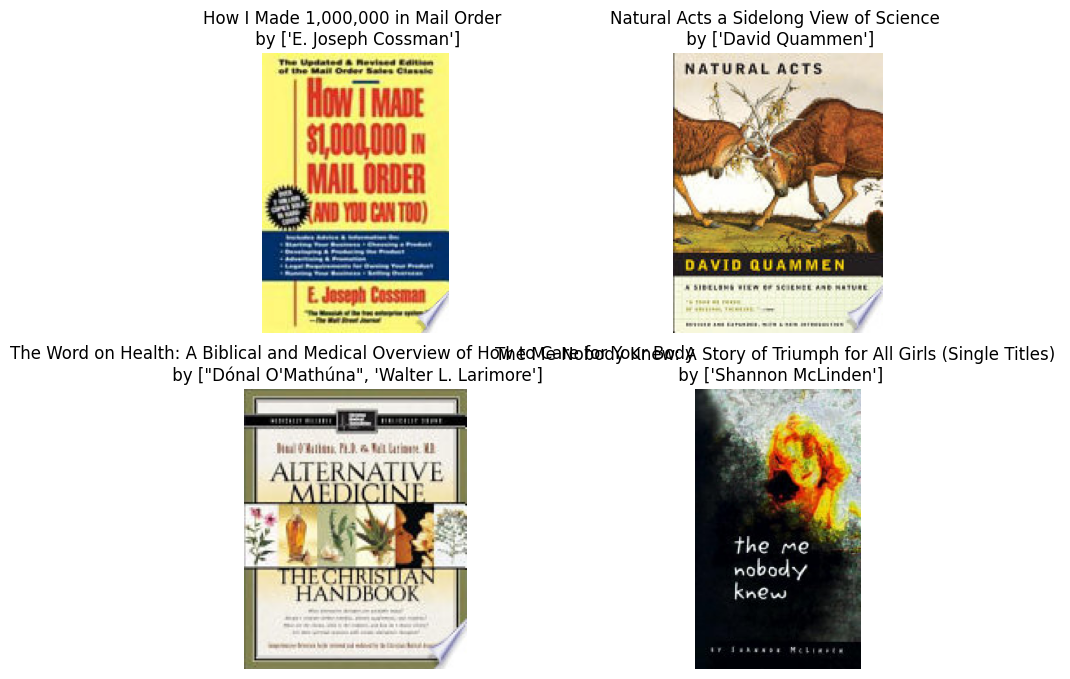

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
title_cover_df = data_df[["Title", 'image', 'authors']]
title_cover_df.dropna(inplace=True)
link = title_cover_df.image.values
title = title_cover_df.Title.values
authors = title_cover_df.authors.values

samples = random.sample(range(len(link)), 4)

for i, ax in enumerate(axes.flat):
    link_sample_image = link[samples[i]]
    image = urlopen(link_sample_image)
    image = np.array(Image.open(image))
    ax.set_title(f"{title[samples[i]]} \n by {authors[samples[i]]}")
    ax.imshow(image)
    ax.axis('off')

plt.show()

In [13]:
data_df.drop(columns=["description", "previewLink", "publisher", "publishedDate", "infoLink", "ratingsCount"], inplace=True)
data_df

,Title,authors,image,categories
5,The Church of Christ: A Biblical Ecclesiology ...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,['Religion']
31,Voices from the Farm: Adventures in Community ...,['Rupert Fike'],http://books.google.com/books/content?id=IjTAB...,['Biography & Autobiography']
33,The Battleship Bismarck,['Stefan Draminski'],http://books.google.com/books/content?id=nxttD...,['History']
42,Tess and the Highlander,['May Mcgoldrick'],http://books.google.com/books/content?id=VmCRS...,['Juvenile Fiction']
43,Beginner's Yoruba (Hippocrene Beginner's Series),['Kayode J. Fakinlede'],http://books.google.com/books/content?id=xLe4n...,['Foreign Language Study']
...,...,...,...,...
212374,Thin Within,"['Judy Halliday', 'Arthur Halliday']",http://books.google.com/books/content?id=L_YV_...,['Health & Fitness']
212392,The Awakening and Selected Stories (Modern Lib...,['Kate Chopin'],http://books.google.com/books/content?id=TDK4u...,['Adultery']
212394,Final things,['Jenny Offill'],http://books.google.com/books/content?id=UbSFB...,['Fiction']
212399,The Orphan Of Ellis Island (Time Travel Advent...,['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,['Juvenile Fiction']


In [14]:
data_df.shape

(40635, 4)

In [15]:
def clean_category(sentences):
    text = sentences.lower()
    # Remove text in square brackets
    re.sub(r"\[.*?\]", "", text)
    # Removing punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Removing words containing digits
    text = re.sub('\w*\d\w*', '', text)

    return text

ex1 = r"'([\w+\s+|\w+\.\s+]*)'"
data_df["authors"] = data_df["authors"].apply(lambda x : ' '.join(re.findall(ex1, x)))
data_df['title_author'] = data_df[["Title", "authors"]].apply(lambda x:' '.join(x.tolist()).lower(), axis=1)

In [16]:
data_df.sample(13)

,Title,authors,image,categories,title_author
219,Poems of the Pearl Manuscript (Exeter Medieval...,Malcolm Andrew Ronald Waldron,http://books.google.com/books/content?id=zAxON...,['Literary Collections'],poems of the pearl manuscript (exeter medieval...
132692,Oscar's Half Birthday,Bob Graham,http://books.google.com/books/content?id=HTLhA...,['Juvenile Fiction'],oscar's half birthday bob graham
122415,Read It! Draw It! Solve It!: Problem Solving w...,Robert E. Reys Mary Lindquist Diana V. Lambdin...,http://books.google.com/books/content?id=bLTZA...,['Education'],read it! draw it! solve it!: problem solving w...
112954,He Died With His Eyes Open,Derek Raymond,http://books.google.com/books/content?id=mvS1E...,['Fiction'],he died with his eyes open derek raymond
148639,The Kitchen Book & The Cook Book,Nnedi Okorafor,http://books.google.com/books/content?id=iOIiE...,['Juvenile Fiction'],the kitchen book & the cook book nnedi okorafor
53315,Queen Mother: A Biblical Theology of Mary's Qu...,Edward Sri,http://books.google.com/books/content?id=wg63v...,['Religion'],queen mother: a biblical theology of mary's qu...
169882,A Woman's Liberation: A Choice of Futures by a...,Connie Willis Sheila Williams,http://books.google.com/books/content?id=zOM5H...,['Fiction'],a woman's liberation: a choice of futures by a...
69483,The Tin Drum,Gunter Grass Günter Grass,http://books.google.com/books/content?id=VkPzA...,['Drummers (Musicians)'],the tin drum gunter grass günter grass
175682,Tuttle's Watch Pck E-j Di,Leanne Brown,http://books.google.com/books/content?id=DuVbB...,['Cooking'],tuttle's watch pck e-j di leanne brown
42158,The Dark Queen,Susan Carroll,http://books.google.com/books/content?id=C3OOD...,['Fiction'],the dark queen susan carroll


In [17]:
data_df.dropna(subset=['title_author'])
data_exploded = data_df.explode('categories')

top_categories = (
    data_exploded['categories']
    .value_counts()  # Count occurrences of each category
    .head(10)        # Get the top 10
    .index           # Extract category names
)

top_books = data_exploded[data_exploded['categories'].isin(top_categories)]

sorted_top_books = top_books.sort_values(by='categories')

In [18]:
sorted_top_books.head()

,Title,authors,image,categories,title_author
26579,White dog,Romain Gary,http://books.google.com/books/content?id=1-qWL...,['Biography & Autobiography'],white dog romain gary
168602,T. E. Lawrence,John E. Mack,http://books.google.com/books/content?id=pnmSi...,['Biography & Autobiography'],t. e. lawrence john e. mack
168572,"Rolling stones,",Mick Jagger Keith Richards Charlie Watts Ron Wood,http://books.google.com/books/content?id=xP_S-...,['Biography & Autobiography'],"rolling stones, mick jagger keith richards cha..."
168464,Justice For All,Jim Newton,http://books.google.com/books/content?id=OkJRt...,['Biography & Autobiography'],justice for all jim newton
64677,Castles In The Air,Judy Corbett,http://books.google.com/books/content?id=d6LGD...,['Biography & Autobiography'],castles in the air judy corbett


In [19]:
sorted_top_books["categories"] = sorted_top_books["categories"].apply(lambda x: literal_eval(x)[0])

In [20]:
label_encoder = LabelEncoder()
sorted_top_books['genre_encoded'] = label_encoder.fit_transform(sorted_top_books['categories'])

In [21]:
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

In [22]:
sorted_top_books

,Title,authors,image,categories,title_author,genre_encoded
26579,White dog,Romain Gary,http://books.google.com/books/content?id=1-qWL...,Biography & Autobiography,white dog romain gary,0
168602,T. E. Lawrence,John E. Mack,http://books.google.com/books/content?id=pnmSi...,Biography & Autobiography,t. e. lawrence john e. mack,0
168572,"Rolling stones,",Mick Jagger Keith Richards Charlie Watts Ron Wood,http://books.google.com/books/content?id=xP_S-...,Biography & Autobiography,"rolling stones, mick jagger keith richards cha...",0
168464,Justice For All,Jim Newton,http://books.google.com/books/content?id=OkJRt...,Biography & Autobiography,justice for all jim newton,0
64677,Castles In The Air,Judy Corbett,http://books.google.com/books/content?id=d6LGD...,Biography & Autobiography,castles in the air judy corbett,0
...,...,...,...,...,...,...
140348,World without women (Sharon),David F. Noble,http://books.google.com/books/content?id=kRHH6...,Social Science,world without women (sharon) david f. noble,9
190895,The Otoes and Missourias;: A study of Indian r...,,http://books.google.com/books/content?id=HKd6n...,Social Science,the otoes and missourias;: a study of indian r...,9
145647,Inside: Life Behind Bars in America,Michael Santos,http://books.google.com/books/content?id=xRebh...,Social Science,inside: life behind bars in america michael sa...,9
125088,Murder of Mercy,Anand Giridharadas,http://books.google.com/books/content?id=hiduA...,Social Science,murder of mercy anand giridharadas,9


In [23]:
sorted_top_books['genre_encoded'].value_counts()

,count
genre_encoded,
3,11011
5,3326
7,2896
4,2448
0,2296
1,1057
6,1009
2,880
9,832


In [24]:
vocab_text = set()
sorted_top_books["title_author"].str.lower().str.split().apply(vocab_text.update)
vocabulary_size = len(vocab_text)
print(vocabulary_size)

41508


In [25]:
TRAINING_SIZE = 20000
VOCAB_SIZE = 41509
MAX_LENGTH = 32
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [26]:
def remove_stopwords(sentence):
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
    sentence = sentence.lower()
    word_list = sentence.split()
    words = [w for w in word_list if w not in stopwords]
    sentence = " ".join(words)

    return sentence

In [27]:
train_df, test_df = train_test_split(sorted_top_books[["title_author", "genre_encoded"]],test_size=0.2,random_state=42,stratify=sorted_top_books["genre_encoded"])

val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print("Training set genre distribution:", train_df["genre_encoded"].value_counts(normalize=True))
print("Testing set genre distribution:", test_df["genre_encoded"].value_counts(normalize=True))
print("Validation set genre distribution:", val_df["genre_encoded"].value_counts(normalize=True))

Training set genre distribution: genre_encoded
3    0.416651
5    0.125875
7    0.109603
4    0.092621
0    0.086897
1    0.039972
6    0.038174
2    0.033302
9    0.031504
8    0.025402
Name: proportion, dtype: float64
Testing set genre distribution: genre_encoded
3    0.419977
5    0.125236
7    0.107075
4    0.087779
0    0.087401
9    0.038214
6    0.036701
1    0.035566
2    0.034431
8    0.027620
Name: proportion, dtype: float64
Validation set genre distribution: genre_encoded
3    0.413545
5    0.126372
7    0.111994
4    0.097616
0    0.086266
1    0.044646
6    0.039728
2    0.032160
9    0.024593
8    0.023080
Name: proportion, dtype: float64


In [28]:
train_sentences = train_df['title_author'].apply(remove_stopwords).values
train_labels = train_df['genre_encoded'].values

test_sentences = test_df['title_author'].apply(remove_stopwords).values
test_labels = test_df['genre_encoded'].values

val_sentences = val_df['title_author'].apply(remove_stopwords).values
val_labels = val_df['genre_encoded'].values

In [29]:
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
vectorize_layer.adapt(train_sentences)

vocabulary = vectorize_layer.get_vocabulary()

with open('vectorizer_vocab.pkl', 'wb') as file:
    pickle.dump(vocabulary, file)

In [30]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels))

In [31]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.data.Dataset'''

  dataset_sequences = dataset.map(lambda text, label: (vectorize_layer(text), label))
  dataset_sequences = dataset_sequences.ragged_batch(batch_size=dataset_sequences.cardinality())
  sequences, labels = dataset_sequences.get_single_element()
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),maxlen=MAX_LENGTH,truncating=TRUNC_TYPE,padding=PADDING_TYPE)
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)
  return dataset_vectorized

In [32]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)
validation_dataset_vectorized = validation_dataset.apply(preprocessing_fn)

In [33]:
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,   275,  6716,   926, 19654], dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)

(<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,  9275,  4258, 17269,   104,    11,     8,   191,
        3284,   934,  7366,  1308, 10365], dtype=int32)>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)



In [34]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )
validation_dataset_final = (validation_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

In [ ]:
def make_model(vocab_size,embedding_dim):
  model = tf.keras.Sequential([
      tf.keras.Input(shape=(MAX_LENGTH,)),
      tf.keras.layers.Embedding(vocab_size, embedding_dim),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(10, activation="softmax")
  ])
  return model

In [ ]:
EMBEDDING_DIM = 100 # Increased embedding dimension further
EPOCHS = 300 # Increased epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True) # Increased patience further
model = make_model(VOCAB_SIZE, EMBEDDING_DIM)
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0005), metrics=["accuracy"]) # Reduced learning rate

history = model.fit(train_dataset_final, validation_data=validation_dataset_final, epochs=EPOCHS, callbacks=[early_stopping])

Epoch 1/300
661/661 [==============================] - 67s 97ms/step - loss: 1.6577 - accuracy: 0.4540 - val_loss: 1.5253 - val_accuracy: 0.4748
Epoch 2/300
661/661 [==============================] - 7s 10ms/step - loss: 1.3347 - accuracy: 0.5296 - val_loss: 1.4152 - val_accuracy: 0.5138
Epoch 3/300
661/661 [==============================] - 6s 9ms/step - loss: 1.0061 - accuracy: 0.6614 - val_loss: 1.3113 - val_accuracy: 0.5808
Epoch 4/300
661/661 [==============================] - 6s 8ms/step - loss: 0.6605 - accuracy: 0.7833 - val_loss: 1.3438 - val_accuracy: 0.6107
Epoch 5/300
661/661 [==============================] - 7s 10ms/step - loss: 0.4357 - accuracy: 0.8681 - val_loss: 1.4710 - val_accuracy: 0.6213
Epoch 6/300
661/661 [==============================] - 5s 8ms/step - loss: 0.2780 - accuracy: 0.9234 - val_loss: 1.5236 - val_accuracy: 0.6326
Epoch 7/300
661/661 [==============================] - 7s 10ms/step - loss: 0.1906 - accuracy: 0.9507 - val_loss: 1.6044 - val_accuracy: 0

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

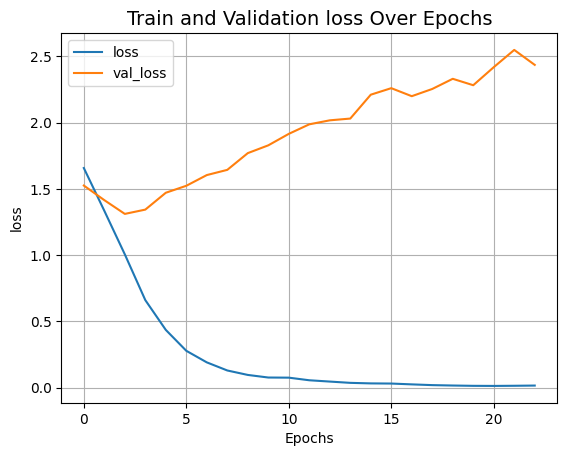

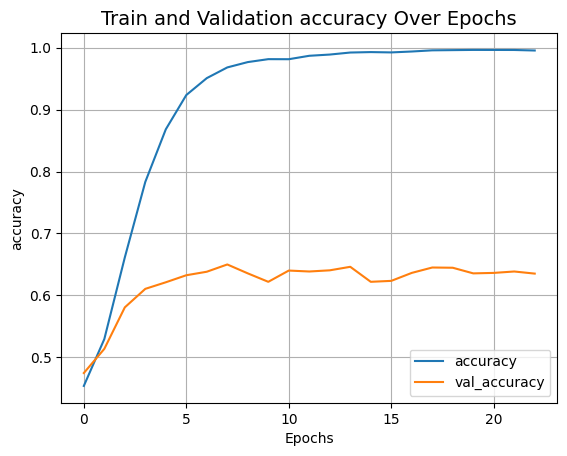

In [ ]:
plot_result("loss")
plot_result("accuracy")

In [ ]:
model.evaluate(test_dataset_final)

83/83 [==============================] - 0s 4ms/step - loss: 1.7138 - accuracy: 0.6345


[1.713768720626831, 0.6345062255859375]

In [ ]:
model.save_weights('model_genre_classification_weights.h5')

In [ ]:
from google.colab import files
files.download('model_genre_classification_weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
import_model = tf.keras.Sequential([
      tf.keras.Input(shape=(MAX_LENGTH,)),
      tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.GlobalAveragePooling1D(),
      tf.keras.layers.Dense(10, activation="softmax")
  ])

In [ ]:
import_model.load_weights('model_genre_classification_weights.h5')

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 32, 100)           4150900   
                                                                 
 bidirectional_8 (Bidirecti  (None, 32, 128)           84480     
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 32, 128)           0         
                                                                 
 global_average_pooling1d_4  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 4236670 (16.16 MB)
Trainable params: 423

In [ ]:
import_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 32, 100)           4150900   
                                                                 
 bidirectional_9 (Bidirecti  (None, 32, 128)           84480     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 32, 128)           0         
                                                                 
 global_average_pooling1d_5  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 4236670 (16.16 MB)
Trainable params: 423